### Import Libraries

In [1]:
import torch 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as T

from data_utils import get_target_model, get_data
from swinv2_large import SwinTransformerFFN
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import RocCurveDisplay 

/home/wlscjf/.conda/envs/labo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Loading and Inference

In [2]:
device = torch.device("cuda:0")
model, processor = get_target_model('swinv2-large', device)
ffn = SwinTransformerFFN("./pretrained/swinv2-large-ffn.pt").to(device).eval()

test_data = get_data("/DATA/jincheol/dataset/new_skin_dataset_split/test", processor)
test_loader = DataLoader(test_data, batch_size=32)

In [3]:
predictions, true_labels, confidence_scores = [], [], []
with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Running Test"):
        X = X.to(device)
        pred = ffn(model(X)).cpu().numpy()
        predicted_labels = (pred >= 0.5).astype(int)
        predictions.extend(predicted_labels)
        true_labels.extend(y)
        confidence_scores.extend(pred)

Running Test: 100%|██████████| 8/8 [00:55<00:00,  6.96s/it]


### Evaluation Metrics

In [4]:
from sklearn.metrics import classification_report

predictions = np.array(predictions, dtype=float)
true_labels = np.array(true_labels, dtype=int)

print(classification_report(true_labels, predictions, 
                          target_names=['Vasculitis/Psoriasis', 'PPD/Statis'],
                          digits=4))

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

print(f"{'Accuracy:':<12} {accuracy:.5f}")
print(f"{'Precision:':<12} {precision:.5f}")
print(f"{'Recall:':<12} {recall:.5f}")
print(f"{'F1 Score:':<12} {f1:.5f}")

                      precision    recall  f1-score   support

Vasculitis/Psoriasis     0.9076    0.9391    0.9231       115
          PPD/Statis     0.9474    0.9197    0.9333       137

            accuracy                         0.9286       252
           macro avg     0.9275    0.9294    0.9282       252
        weighted avg     0.9292    0.9286    0.9287       252

Accuracy:    0.92857
Precision:   0.92747
Recall:      0.92942
F1 Score:    0.92821


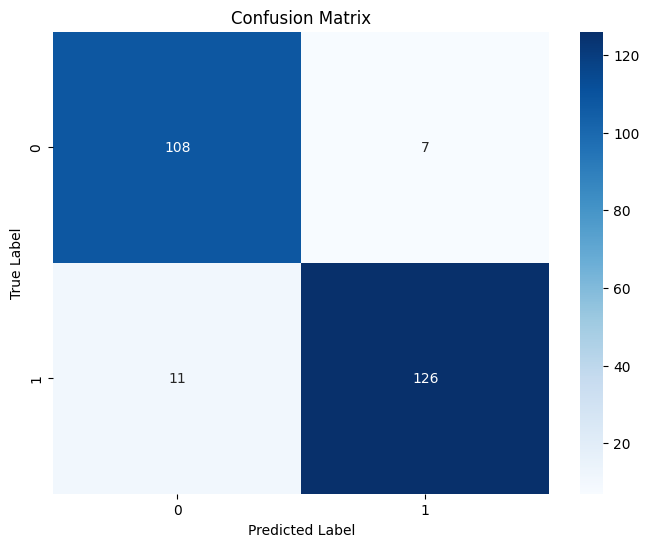

In [5]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

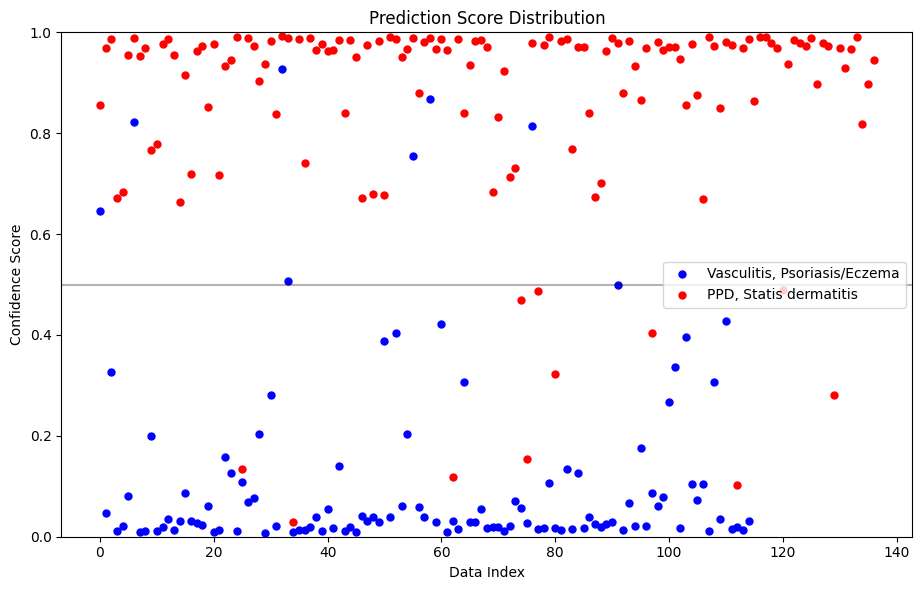

In [6]:
x = np.arange(len(confidence_scores))
y = np.array(confidence_scores)

t = np.where(true_labels[:-1] != true_labels[1:])[0][0] + 1


plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.title("Prediction Score Distribution")
plt.scatter(x[:t], y[:t], color='b',s=100, marker='.', label='Vasculitis, Psoriasis/Eczema')
plt.scatter(x[t:] - t, y[t:], color='r',s=100, marker='.', label='PPD, Statis dermatitis')
plt.axhline(y=0.5, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Data Index')
plt.ylabel('Confidence Score')
plt.ylim([0, 1])
plt.legend()

plt.tight_layout()
plt.show()

#0.50042105

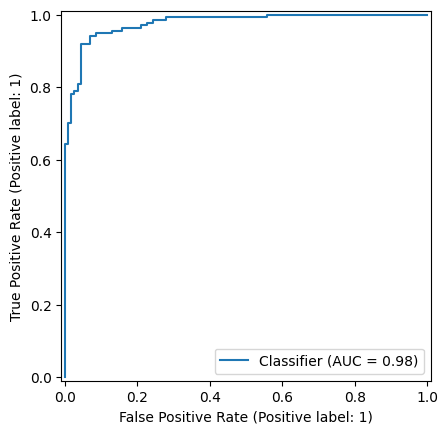

In [7]:
RocCurveDisplay.from_predictions(true_labels, confidence_scores)
plt.show()

### Error Analysis

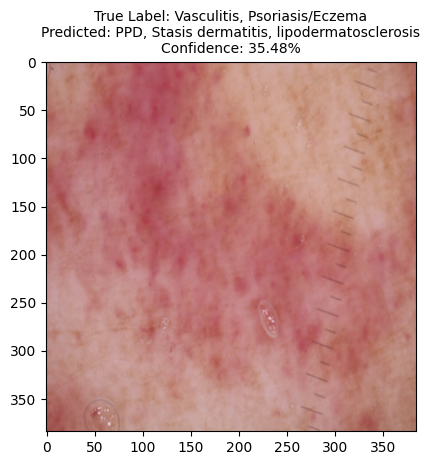

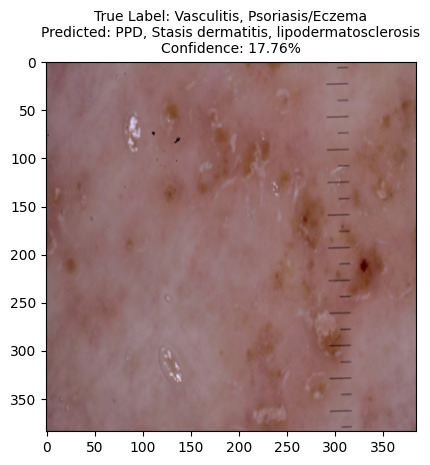

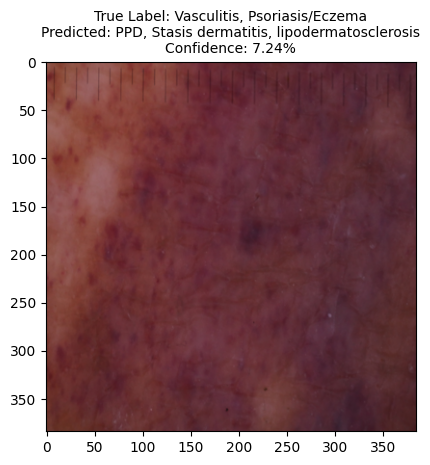

In [8]:
# swin_unnormalize
unnormalize = T.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# vit_unnormalize
# unnormalize = T.Normalize(
#     mean=[-1,-1,-1],
#     std=[1/0.5, 1/0.5, 1/0.5]
# )



count = []
for i in range(len(true_labels)):
    if predictions[i] != true_labels[i]:
        count.append(i)

for j in count[:3]:
    restored_img = unnormalize(test_data[j][0])
    restored_img = torch.clamp(restored_img, 0, 1)
    test_img = restored_img.permute(1, 2, 0)
    # plt.imshow(test_img)
    # plt.title(f"True Label: {true_labels[j]} | Predicted: {predictions[j]} | Confidence: {100*confidence_scores[j]: .2f}%" )
    # plt.show()
    
    
    plt.imshow(test_img)
    if true_labels[j]==0:
        plt.title(f"True Label: Vasculitis, Psoriasis/Eczema\nPredicted: PPD, Stasis dermatitis, lipodermatosclerosis\nConfidence: {100 * (1-confidence_scores[j]):.2f}%", fontsize=10)
    else: #true_label==1
        plt.title(f"True Label: PPD, Stasis dermatitis, lipodermatosclerosis\nPredicted: Vasculitis, Psoriasis/Eczema\nConfidence: {100 * confidence_scores[j]:.2f}%", fontsize=10)
    plt.show()
    

In [ ]:
for name, module in model.named_children():
    print(f"Layer: {name}, Type: {module}")

Layer: swinv2, Type: Swinv2Model(
  (embeddings): Swinv2Embeddings(
    (patch_embeddings): Swinv2PatchEmbeddings(
      (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Swinv2Encoder(
    (layers): ModuleList(
      (0): Swinv2Stage(
        (blocks): ModuleList(
          (0-1): 2 x Swinv2Layer(
            (attention): Swinv2Attention(
              (self): Swinv2SelfAttention(
                (continuous_position_bias_mlp): Sequential(
                  (0): Linear(in_features=2, out_features=512, bias=True)
                  (1): ReLU(inplace=True)
                  (2): Linear(in_features=512, out_features=6, bias=False)
                )
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=False)
                (value): Linear(in_features

: 

### Visualization

input_size: torch.Size([3, 384, 384])


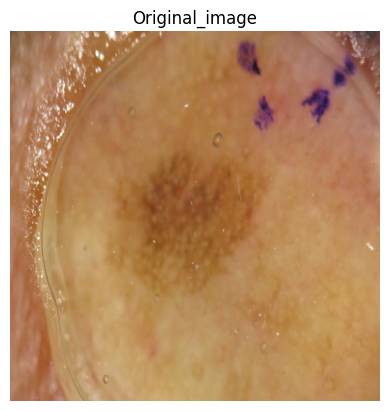

rgb_img: (384, 384, 3)
(384, 384)


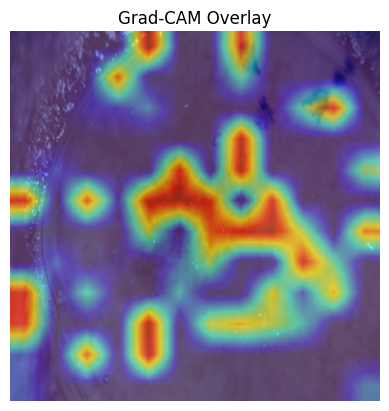

In [10]:
import cv2
from transformers import AutoImageProcessor
from PIL import Image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


img_path="/DATA/jincheol/dataset/skin_dataset_split/test/class0_others/class0_others_78.jpg"
processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft", use_fast=True)
input_image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
input_tensor = processor(Image.open(img_path) , return_tensors="pt")["pixel_values"]
input_tensor = input_tensor.to(0) 

print(f"input_size: {input_tensor.squeeze(0).size()}")

#swin_transformer
unnormalize = T.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)


#vision_transformer
# unnormalize = T.Normalize(
#     mean=[-1,-1,-1],
#     std=[1 / 0.5, 1 / 0.5, 1 / 0.5]
# )


input_tensor = unnormalize(input_tensor)
input_tensor = torch.clamp(input_tensor, 0, 1)  # [0, 1] 범위로 조정

rgb_img = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.imshow(rgb_img)
plt.axis("off")
plt.title("Original_image")
plt.show()

print(f"rgb_img: {rgb_img.shape}")




# vit_reshape
# def reshape_transform(tensor, height=14, width=14):
#     result = tensor[:, 1:, :].reshape(tensor.size(0),
#                                       height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result



#swin_transformer_reshape  
def reshape_transform(tensor, height=12, width=12):
    result = tensor.reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result



# We have to specify the target we want to generate the CAM for.
layer = model.swinv2.encoder.layers[-1].blocks[-1].layernorm_after
# layer=model.model.vit.encoder.layer[11].attention.attention

targets = [ClassifierOutputTarget(1)]

#targets = BinaryClassifierOutputTarget(1)
model.eval()

# Construct the CAM object once, and then re-use it on many images.
with EigenCAM(model=model, target_layers=[layer], reshape_transform=reshape_transform) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

  #print(grayscale_cam.shape)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  
  print(grayscale_cam.shape)  # 출력 형태 확인
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

  
plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM Overlay")
plt.show()

###  Concepts_Extract

In [1]:
import os
import random
import utils
import data_utils
import json
import cbm
import plots
from data_utils import get_target_model, get_data
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/ham10000_cbm_2024_11_25_07_50"
device = "cuda:1"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)


/home/wlscjf/.conda/envs/labo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sangjun/study/cbm/cbm.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

In [2]:
with open('data/ham10000.txt', "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

In [3]:
_, processor = get_target_model('swinv2-large', device)

test_data = get_data("/DATA/jincheol/dataset/HAM10000_split/test", processor)

predictions, true_labels = utils.get_accuracy_cbm(model, test_data, device, batch_size=25)


accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

print(f"{'Accuracy:':<12} {accuracy:.5f}")
print(f"{'Precision:':<12} {precision:.5f}")
print(f"{'Recall:':<12} {recall:.5f}")
print(f"{'F1 Score:':<12} {f1:.5f}")


100%|██████████| 61/61 [00:44<00:00,  1.38it/s]

Accuracy:    0.77756
Precision:   0.57304
Recall:      0.50855
F1 Score:    0.51796


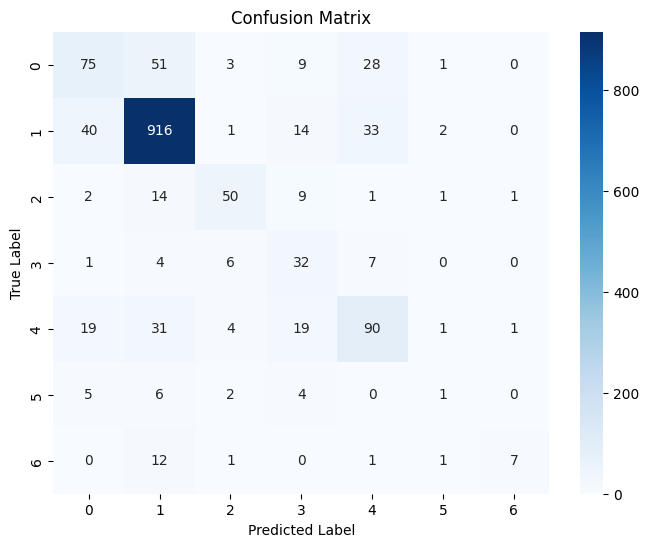

In [4]:
cm = confusion_matrix(true_labels, predictions)

#print(true_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

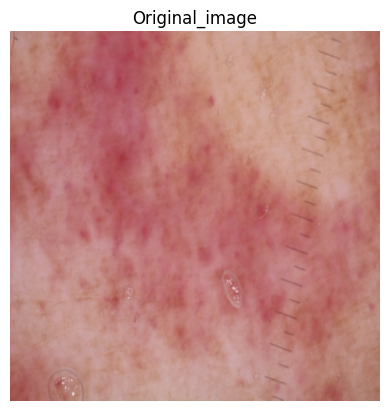

Image:0 Gt: Vasculitis, Psoriasis/Eczema, Pred: PPD, Statis dermatitis
['most commonly on the', 'NOT appear thickened or inflamed, with', 'NOT may cause itching or a burning sensation', 'severity varies from person to person', 'NOT especially around joints;']


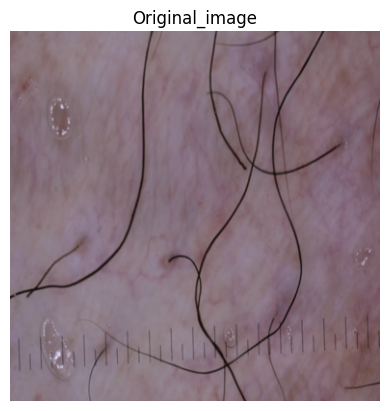

Image:1 Gt: Vasculitis, Psoriasis/Eczema, Pred: Vasculitis, Psoriasis/Eczema
['most commonly on the', 'NOT appear thickened or inflamed, with', 'NOT may cause itching or a burning sensation', 'NOT severity varies from person to person', 'especially around joints;']


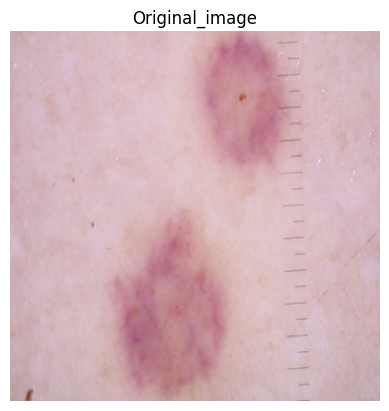

Image:2 Gt: Vasculitis, Psoriasis/Eczema, Pred: Vasculitis, Psoriasis/Eczema
['NOT most commonly on the', 'appear thickened or inflamed, with', 'may cause itching or a burning sensation', 'severity varies from person to person', 'especially around joints;']


In [ ]:
#to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

#test_data갯수는 252개



with torch.no_grad():
    for i in range(3):
        image, label = test_data[i]
        x, _ = test_data[i]
        x = x.unsqueeze(0).to(device)
        
        #print(f'x_shape: {x.shape}')
        #display(image.resize([320,320]))
        
        image = unnormalize(image)
        image = torch.clamp(image, 0, 1)  # [0, 1] 범위로 조정

        rgb_img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        plt.imshow(rgb_img)
        plt.axis("off")
        plt.title("Original_image")
        plt.show()
        
        outputs, concept_act = model(x)
        #print(outputs)
        #print(concept_act.shape)
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=1)
        
        #print(top_logit_vals)
        #print(top_classes)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt: {}, Pred: {}".format(i, classes[int(label)], classes[top_classes[0]]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]

           # print(f"concept_act size: {concept_act.shape}")
            #print(f"concepts size: {len(concepts)}")
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            
            print(feature_names[:5])
            
            #plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)